In [1]:
import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


Solving the heat equation in 1 d on a periodic boundary with skfem
$$\partial_t u = D \partial_{xx} u $$

The weak form 
\begin{align}
 \int_\Omega \partial_t u v ds & = \int_\Omega D(\partial_{xx} u) v ds  \\
 & = - \int_\Omega D (\partial_s u) (\partial_s v ) ds 
 \end{align}
with $v \in H^1$ where $H^1$ is a Sobolev space. 
I have dropped the boundary term when integrating by parts, because the space is periodic and so has no boundary.

In [3]:
# routines that we will need here
from skfem.models.poisson import laplace, mass
from scipy.sparse.linalg import splu

In [5]:
npoints = 50 
m1 = skfem.mesh.MeshLine(np.linspace(0, 2*np.pi, npoints))  # regular 1d mesh 
mp = skfem.mesh.MeshLine1DG.periodic(m1, [0], [npoints-1])  # a mesh for discontinous element problems, and made to be periodic
# we seem to have a periodic mesh in 1d with theta going from 0 to 2 pi
# however mp.p has almost (but not quite) twice as many points, which is kind of surprising

(98,) (50,)


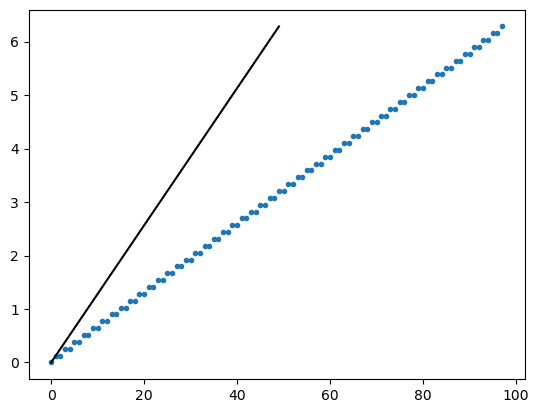

In [7]:
# interesting things about the discontinuous mesh we are using for the periodic system
phi_m = np.squeeze(mp.p)
phi = np.linspace(0, 2*np.pi, npoints) 
plt.plot(phi_m,'.')  # this is kind of weird, probably for doing Reiman solvers and things like that 
plt.plot(phi,'k-')
print(phi_m.shape, phi.shape)

In [9]:
element = skfem.ElementLineP2()  # choose an element type  (or ElementLineP1)
basis = skfem.Basis(mp, element)  # make a basis 

In [11]:
basis.doflocs[0]  # these seem to be phi values for the basis, and they repeat for some reason
# this is what you need to use for phi values 

array([0.12822827, 0.25645654, 0.38468481, 0.51291309, 0.64114136,
       0.76936963, 0.8975979 , 1.02582617, 1.15405444, 1.28228272,
       1.41051099, 1.53873926, 1.66696753, 1.7951958 , 1.92342407,
       2.05165235, 2.17988062, 2.30810889, 2.43633716, 2.56456543,
       2.6927937 , 2.82102197, 2.94925025, 3.07747852, 3.20570679,
       3.33393506, 3.46216333, 3.5903916 , 3.71861988, 3.84684815,
       3.97507642, 4.10330469, 4.23153296, 4.35976123, 4.48798951,
       4.61621778, 4.74444605, 4.87267432, 5.00090259, 5.12913086,
       5.25735913, 5.38558741, 5.51381568, 5.64204395, 5.77027222,
       5.89850049, 6.02672876, 6.15495704, 6.28318531, 0.06411414,
       0.19234241, 0.32057068, 0.44879895, 0.57702722, 0.70525549,
       0.83348377, 0.96171204, 1.08994031, 1.21816858, 1.34639685,
       1.47462512, 1.60285339, 1.73108167, 1.85930994, 1.98753821,
       2.11576648, 2.24399475, 2.37222302, 2.5004513 , 2.62867957,
       2.75690784, 2.88513611, 3.01336438, 3.14159265, 3.26982

In [29]:
# create operators 
diffusivity = 1.0
L = diffusivity * skfem.asm(laplace, basis)   # assemble Laplacian op
M = skfem.asm(mass, basis)   # mass op for integrating 
dt = 0.01
theta = 0.5  # Crank–Nicolson
A = M + theta * L * dt  # note that L is an inner produc with a minus sign as given in the above weak form 
B = M - (1 - theta) * L * dt
backsolve = splu(A.T).solve  # .T transpose as splu prefers CSC which is a particular sparse matrix format
# this creates something like an inverse matrix 
# backsolve(B @ u) gives A^-1 (B u) but with LU decomp
#   solve for x such that Ax = Bu computed using LU decomp of A
# see https://en.wikipedia.org/wiki/LU_decomposition and 
# https://docs.scipy.org/doc/scipy-1.14.0/reference/generated/scipy.sparse.linalg.splu.html

# take n integration steps 
# needed globals are B, dt
def evolve(n,t,u):
    for i in range(n):
        t = t + dt
        u =  backsolve(B @ u)
    return t,u

In [31]:
# check our time step
dphi = phi[1]- phi[0]
ratio = dphi**2/diffusivity
print('{:.3f}'.format(ratio) )
# compare this to dt  (CFL like condition)

0.016442


The Crank-Nicolson step for the diffusive part for $\partial_t u = F u  $  with $F$ a linear op is the following
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{ F}{2 \Delta t} \right) u^{n+1} = \left(1 + \frac{1}{2 \Delta t} F\right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ F}{2 \Delta t} \right)^{-1} \left(1 + \frac{1}{2 \Delta t} F\right)u^n
\end{align}

(98,)


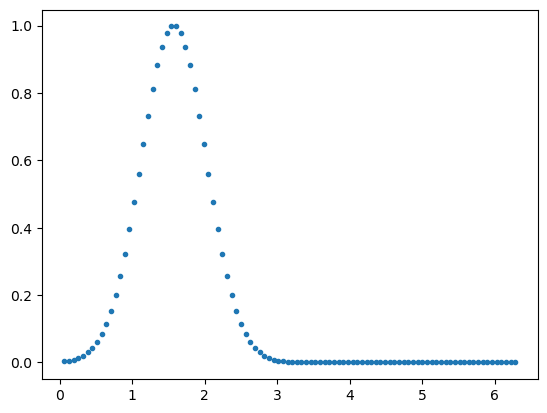

In [33]:
# make some initial conditions 
phi0 = np.pi/2
sig2 = 0.2
u_init = np.exp(-0.5 *(basis.doflocs[0] - phi0)**2/sig2)  
plt.plot(basis.doflocs[0],u_init,'.')
t=0.0
u = u_init; 
n=10
print(u.shape)

Text(0.5, 1.0, 't = 1.0')

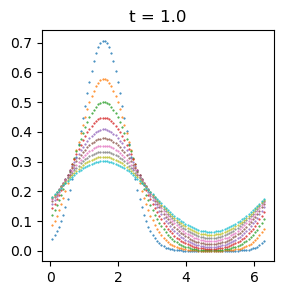

In [35]:
# run a simulation of heat equation 
fig,ax = plt.subplots(1,1,figsize=(3,3))
for j in range(10):
    t,u = evolve(n,t,u)
    ax.plot(basis.doflocs[0],u,'.',ms=1)
tlabel = 't = {:.1f}'.format(t)
ax.set_title(tlabel)
    
#print(t)

In [ ]:
# looks okay 

Now let's try to do the wave equation!  We can use similar operators and the same mesh

Our equation of motion are 
$$ \ddot u = c^2 \partial_{xx} u $$
or equivalently using a velocity variable,  
\begin{align}
\dot u &= v \\
\dot v &= c^2 \partial_{xx} u 
\end{align}

I am building upon the following example https://github.com/kinnala/scikit-fem/blob/10.0.0/docs/examples/ex44.py


In [234]:
npoints = 50 
m1 = skfem.mesh.MeshLine(np.linspace(0, 2*np.pi, npoints))  # regular 1d mesh 
mp = skfem.mesh.MeshLine1DG.periodic(m1, [0], [npoints-1])  # a mesh for discontinous element problems, and made to be periodic
element = skfem.ElementLineP2()  # choose an element type  (or ElementLineP1)
basis = skfem.Basis(mp, element)  # make a basis 

In [294]:
# using the same basis  as before
N = basis.N
L = skfem.asm(laplace,basis)
M = skfem.asm(mass,basis)
I = scipy.sparse.identity(N)

c = 1.0   # speed of waves 
dt = .05

# reduction to first order system in time
A0 = skfem.bmat([[I, None],  # block matrix form for first u,v=dot u   
           [None, M]], "csc")   # I don't understand why I and M on diag here, why not M,M?

B0 = skfem.bmat([[None, I],
           [-c ** 2 * L, None]], "csc")   # this makes sense as it is the operator in crank nicolson

theta = 0.5  #crank nicolson
A = A0 + theta * B0 * dt
B = A0 - (1. - theta) * B0 * dt
backsolve = splu(A).solve   # why no transpose here? probably because A0, B0 are "csc" format

# timestepping, U is now containing two things  U=[u,v]
# globals are B, dt
def evolvew(n,t,U):
    for i in range(n):
        t = t + dt
        U = backsolve(B @ U)
    return t, U

# check our time step
dphi = phi[1]- phi[0]
ratio = dphi/c  # should be in units of time 
print('{:.3f}'.format(ratio) )
# compare this to dt (CFL like condition)

0.128


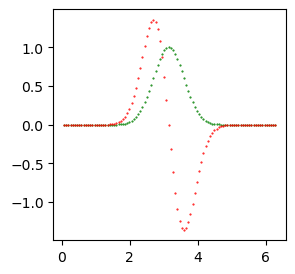

In [304]:
# make some initial conditions 
phi0 = np.pi
sig2 = 0.2
u_init = np.exp(-0.5 *(basis.doflocs[0] - phi0)**2/sig2)    # we start with a positive position 
v_init = -c*u_init * (basis.doflocs[0] - phi0)/sig2  # take derivative for velocity 
U= np.concatenate((u_init, v_init))
#plt.plot(basis.doflocs[0],v_init,'r.')  #velocity is red 
#plt.plot(basis.doflocs[0],u_init,'g.')  #position is green
N = int(U.shape[0]/2)
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(basis.doflocs[0],U[0:N],'g.',ms=1)   # position is green 
ax.plot(basis.doflocs[0],U[N:],'r.',ms=1)  #velocity is red 
t=0.0
n=10
#print(u.shape)

# We need to differentiate our function and multiply it by c to get it to be a velocity of a moving pulse to the right. 


Text(0.5, 1.0, 't = 4.0')

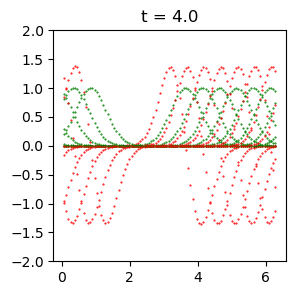

In [306]:

# run a simulation of wave equation 
fig,ax = plt.subplots(1,1,figsize=(3,3))
for j in range(8):
    t,U = evolvew(n,t,U)
    N = int(U.shape[0]/2)
    
    ax.plot(basis.doflocs[0],U[0:N],'g.',ms=1)
    ax.plot(basis.doflocs[0],U[N:],'r.',ms=1)
    ax.set_ylim([-2,2])
tlabel = 't = {:.1f}'.format(t)
ax.set_title(tlabel)
    
#print(t)

In [ ]:
# yay! it worked! 


Now trying to see if we can do a fourth order PDE on a loop 
I think we need the Hermite element

In [311]:
npoints = 50 
m1 = skfem.mesh.MeshLine(np.linspace(0, 2*np.pi, npoints))  # regular 1d mesh 
mp = skfem.mesh.MeshLine1DG.periodic(m1, [0], [npoints-1])  # a mesh for discontinous element problems, and made to be periodic
 
elementg = skfem.ElementLineHermite()  # choose an element in Sobolev space H2
basis = skfem.Basis(mp, elementg)  # make a basis 

LinAlgError: Singular matrix

Examples of making your own mesh with points and a Delaunay triangulation
https://github.com/kinnala/scikit-fem/discussions/705

